# Final Report: Programming Languages and GitHub
By Daniel Fraser and Peter Laskai

# Describe project goals and why it is interesting 
We plan to use this data to predict which languages are being used, what they’re being used for (commercial, fun, etc). The data behind Github is fascinating because it is one the most used version control software out there and allows the public to see the trend of languages throughout the years and see what type of projects people create, and how they collaborate with one another.

# Describe data collection/source of data, data format, data preprocessing
This dataset gives us info on what languages are used, its files (including their contents) and their size along with info on commits. We will use a combination of the data from bigquery along with using Github’s official api using javascript. Bigquery’s data is listed as tables, while the api will give us info in the form of an API response as json file. With bigquery, we have to eliminate rows that have a date before the creation of github (which is about 0.04% (10 million) which is most likely an error from importing data to bigQuery) of the total rows. With the api, we eliminate some of the redundant information such as owner of repo (since unless you’re searching, you get the repo based off the username).

One of our data collection source was Octokit’s [rest.js](https://github.com/octokit/rest.js), a JavaScript based API scraper tool adopted by the GitHub team. From there we could access a large amount github data arranging from, user info, repository details, gists, issues, and pull requests from 24 million users.This is an example of a “query” using rest.js:
```
//This specific function gets all the info of JavaFXMusicLibrary repository from user PrL327
octokit.repos.get({
  owner: 'prl327',
  repo: 'JavaFXMusicLibrary'
}).then(({data}) => {
  console.log(data);
}); 
```
 Right now since we can only evaluate data that is public like public organizations and public repos, we had to put a safeguard in which we return 0, which in the end we filter out. We also have to worry about hitting the query limit for the api which is 1000 queries a hour. We actually combined the use of BigQuery and Rest.js in one example. We had a csv file which contained two columns for username and repository, with about 10,000 rows. to easily process that csv file through our query we needed to convert it to a JSON for easy parsing. For this we used csv a node library and it's resepective functions to do the conversion, it produce an object like such:
 ```
 {
     "User": "prl327",
     "Repository": "JavaFXMusicLibrary"
 }
 ```
 And so on for 10,000 more user/repo combinations.

# Describe contents of data in detail (write code to analyse and visualize it) 


### Why Github?
Githhub is a very active community with millions of user constantly collaborating and contributing to projects.  We gathered contributer data using the github api since bigquery doesn't have any tables with information on contributors. We were surpised to find that most of the projects hosted there on github are only worked by only one person.

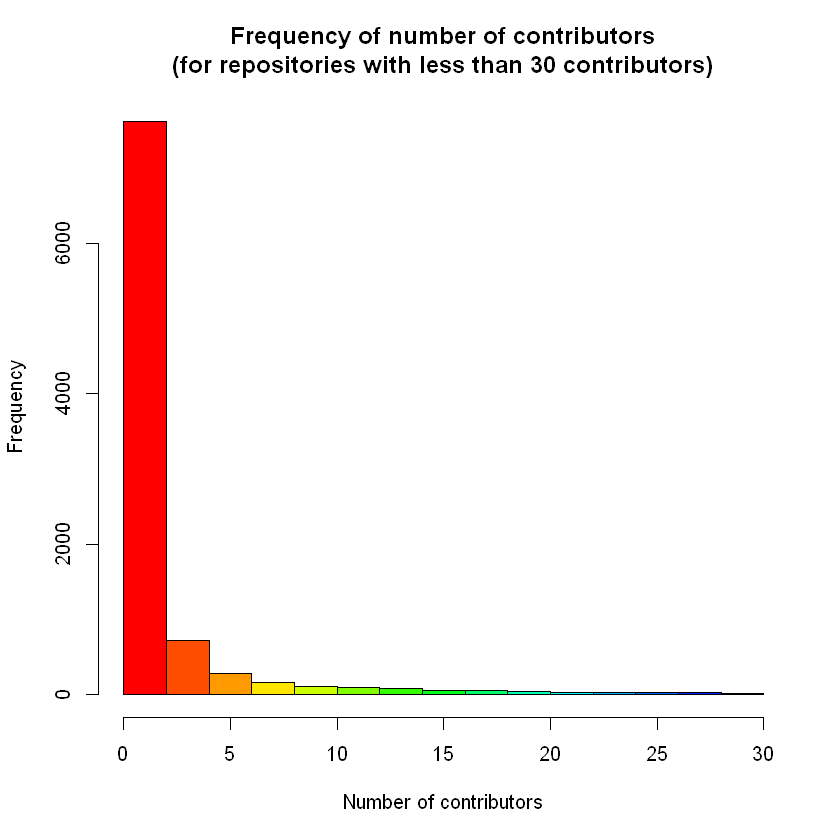

In [1]:
repos <- read.csv("repos.csv", header = TRUE)
hist(repos$contributors[repos$contributors > 0 & repos$contributors < 30], 10,
     col = rainbow(20), xlab = "Number of contributors", main = "Frequency of number of contributors\n(for repositories with less than 30 contributors)")

## Languages Used the most

We filtered out the `languages` table from bigquery's dataset to only show the top 15 languages by occurrences:
```sql
SELECT
  name,
  COUNT(*) AS occurences
FROM
  `bigquery-public-data.github_repos.languages` AS l,
  UNNEST(l.LANGUAGE)
GROUP BY
  name
ORDER BY
  occurences DESC
  limit 15
```

In [32]:
import plotly as py
from plotly.graph_objs import *
import pandas
col = ['name', 'occurences', '']
csv_data = pandas.read_csv('most_languages.csv', names=col)
lang = csv_data.name.tolist()
occ = csv_data.occurences.tolist()
lang.pop(0)
occ.pop(0)
x = lang
y = occ

py.offline.init_notebook_mode(connected=True)

layout = Layout(
    title='Top 15 Languages',
    xaxis=dict(
        title='Languages',
        titlefont=dict(
            family='Arial, arial',
            size=18,
            color='#7f7f7f'
    )),
    yaxis=dict(
        title='Occurences',
        titlefont=dict(
            family='Arial, arial',
            size=18,
            color='#7f7f7f'
    ))
)

py.offline.iplot({
    "data": [Scatter(x=lang, y=occ)],
    "layout": layout
})

Unsuprisingly the biggest languages used in the world round up the top 15 used languages in Github. JavaScript takes the top with 1.2 Million Occurrences in our dataset. Javascript is also a heavily modified langauage with sub languages like JQuery, NodeJS, ReactJS, and AngularJS. 

## Languages Used the Least

We filtered out the `languages` table from bigquery's dataset to only show the 15 languages with the lowest occurrences:
```sql
SELECT
  name,
  COUNT(*) AS occurences
FROM
  `bigquery-public-data.github_repos.languages` AS l,
  UNNEST(l.LANGUAGE)
GROUP BY
  name
ORDER BY
  occurences
  limit 15```

In [30]:

col = ['name', 'occurences', '']
csv_data = pandas.read_csv('least_languages.csv', names=col)
lang = csv_data.name.tolist()
occ = csv_data.occurences.tolist()
lang.pop(0)
occ.pop(0)
x = lang
y = occ

layout = Layout(
    title='Least Used 15 Languages',
    xaxis=dict(
        title='Languages',
        titlefont=dict(
            family='Arial, arial',
            size=18,
            color='#7f7f7f'
    )),
    yaxis=dict(
        title='Occurences',
        titlefont=dict(
            family='Arial, arial',
            size=18,
            color='#7f7f7f'
    ))
)


py.offline.iplot({
    "data": [Scatter(x=lang, y=occ)],
    "layout": layout
})

Processing through the data produced some interesting results. First to note Markdown is noted as one of the lead used but when visiting GitHub you see README.md in almost every repo. In this case the Dataset from GoogleBigquery does not count README files when referencing language data. Ring is a language we have actually never heard before. If you search GitHub you'll find only 18 repositories that use Ring. The lanuage is a mult-paradigmn language that can be used for apps on multiple OSes and with a GCC compiler.

## 15 Languages using the most bytes

For bytes we continued analyzed the dataset's `langauges` table this time getting the sum of bytes:
```sql
SELECT
  name,
  SUM(bytes) AS totalBytes
FROM
  `bigquery-public-data.github_repos.languages` AS l,
  UNNEST(l.LANGUAGE)
GROUP BY
  name
ORDER BY
  totalBytes DESC
limit 15
```

In [29]:

py.offline.init_notebook_mode(connected=True)

col = ['name', 'totalBytes', '']
csv_data = pandas.read_csv('most_bytes.csv', names=col)
lang = csv_data.name.tolist()
lang.pop(0)
byte = csv_data.totalBytes.tolist()
byte.pop(0)


x = lang
y = byte

trace = Scatter(
    x=lang,
    y=byte,
    fill='tozeroy'
)


labels = lang
values = byte


py.offline.iplot([trace])

*QUICK NOTE: B stands for Billion not bytes, i.e 36.48B is 36.48 Billion Bytes thus 36GB

Analyzing byte data from GitHub we see C dominate in the amount with 6.3 TerraBytes of code hosted on the GitHub service. Looking over Repositories that use the C language one of Github's most popular and contributed repository is almost 100% written in C, Linux. Linux the UNIX based OS and it's kernel is hosted on GitHub with so many contributers it displays an infinite amount of contributers in its stats. Since Linux is an OS it is bound to have many C files and in turn bytes as well, but Linux is not the only C repo, in the top 15 langauges graph, it shows there are almost 300k projects written in C language and possibly more. Coming in a far second is JavaScript, GitHub's most popular language at 1.25 Terabytes of code written amongst the 1.11 Million Javascript projects on Github. We also see other popular langagues like Python, Java, HTML, and PHP in that list. CSS GitHub's second most popular language only has about 155 Gb of data, but it's a style sheet language mainly unlike the rest of the languages up there.

## 15 Languages that use the Least Amount of Bytes

We did the same here except looked at the least amount of bytes:
```sql
SELECT
  name,
  SUM(bytes) AS totalBytes
FROM
  `bigquery-public-data.github_repos.languages` AS l,
  UNNEST(l.LANGUAGE)
GROUP BY
  name
ORDER BY
  totalBytes
limit 15
```

In [28]:

py.offline.init_notebook_mode(connected=True)

col = ['name', 'totalBytes', '']
csv_data = pandas.read_csv('least_bytes.csv', names=col)
lang = csv_data.name.tolist()
lang.pop(0)
byte = csv_data.totalBytes.tolist()
byte.pop(0)

x = lang
y = byte

trace = Scatter(
    x=lang,
    y=byte,
    fill='tozeroy'
)


labels = lang
values = byte


py.offline.iplot([trace])

DataWeave has the least amount of bytes hosted on GitHub. We learned that Dataweave is a querying language that works with Mule another query language with Java. One thing that was surprising is a querying language has least amount of bytes coded compared to DogeScript, a language developed based in JavaScript, and constantly used and updated.

# 4. Describe possible applications of this data, Including your ideas for the next phase
An application for this data is seeing what type of programs use more storage than others allowing a system administrator to give certain users more storage based on their favorite language. One interesting application will be seeing which libraries are commonly used (also see what type of libraries are most commonly used like reading json/csv files, machine learning, etc.) and can go a step further and seeing what are the top 10 libraries for each language for each year. We will be using this data to predict which languages will be expected to be used the most in 2018 and 2019. Since we also get information like commits, we can use this data to see average commits, average time between commits, and see average lifetime of a repository. We are also able to see contents of every file in any public repository, so we can use the contents to teach a machine learning algorithm to tell the difference between python and javascript or between java and c++, etc.

# Machine Learning - Language Interpreting

With the amount of programs on github, we were able to train a model to determine what language a program is based on the top 8 programming languages which were Java, C, C++, C#, Objective-c, Python, Ruby, and Javascript. We used regex to create features since programming languages require a structure to tell one apart from another. For example, Java, C, C++, and many other oop languages share the same for loop structure but have other distinct features that can differentiate each one. One problem which is hard to avoid is small programs that have the same structure as other languages but without the distinct features which can cause a false reading. One way to fix this is to require a certain number of lines to increase the chance of a distinct feature occurring but even then it could still fail.

We are also able to see contents of every file in any public repository, so we can use the contents to teach a machine learning algorithm to tell the difference between python and javascript or between java and c++, etc. For this process we went through we gathered the data from the Github's dataset on Google where we looked at both their `files` table and `content` table. We had to `JOIN` both tables based on file ids so we could get filenames and content together. From there we decided for our machine learning algorithm we would use Decision Trees to train our machine in recognizing the 8 most popular langauges.

# Conclusion

## Acknowledgments
* [Github API (js)](https://github.com/octokit/rest.js)
* [csv (js)](https://www.npmjs.com/package/csv)
* [jsonfile (js)](https://www.npmjs.com/package/jsonfile)
* [BigQuery](https://bigquery.cloud.google.com)
* [Plotly](https://plot.ly/python/)